<a href="https://colab.research.google.com/github/adinesia/PySparkProject/blob/main/PySpark_Clustering_Iris_Flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 59kB/s 
     |████████████████████████████████| 204kB 44.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=248e69bcec1db18523946604a7ab7e1ecbeab01428ac8521f1831bfda95dc6b1
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# pyspark lib
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import  StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

%matplotlib inline

In [5]:
# Building spark session

spark = SparkSession.builder\
        .master("local[*]")\
        .appName('Iris Unsupervise')\
        .getOrCreate()

In [6]:
# Load iris dataset
df = pd.read_csv('Iris.csv')
iris_df = spark.createDataFrame(df)

In [ ]:
iris_df.printSchema()

root
 |-- Id: long (nullable = true)
 |-- SepalLengthCm: double (nullable = true)
 |-- SepalWidthCm: double (nullable = true)
 |-- PetalLengthCm: double (nullable = true)
 |-- PetalWidthCm: double (nullable = true)
 |-- Species: string (nullable = true)



In [ ]:
iris_df.count()

150

In [7]:
iris_df.show(5)

+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 5 rows



In [8]:
#  unique values in species
iris_df.select('species').distinct().rdd.map(lambda r: r[0]).collect()

['Iris-virginica', 'Iris-setosa', 'Iris-versicolor']

In [ ]:
# Counting velues in species
iris_df.groupBy('species').count().show()

+---------------+-----+
|        species|count|
+---------------+-----+
| Iris-virginica|   50|
|    Iris-setosa|   50|
|Iris-versicolor|   50|
+---------------+-----+



In [9]:
# Checking missing values
iris_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in iris_df.columns]).show()

+---+-------------+------------+-------------+------------+-------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|Species|
+---+-------------+------------+-------------+------------+-------+
|  0|            0|           0|            0|           0|      0|
+---+-------------+------------+-------------+------------+-------+



In [10]:
# converting the input data to features in column
vAssembler = VectorAssembler(inputCols=['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm',], outputCol="features")
viris_df = vAssembler.transform(iris_df)

In [11]:
viris_df.show(5)

+---+-------------+------------+-------------+------------+-----------+-----------------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|         features|
+---+-------------+------------+-------------+------------+-----------+-----------------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|
+---+-------------+------------+-------------+------------+-----------+-----------------+
only showing top 5 rows



In [12]:
# index the spesies
indexer = StringIndexer(inputCol='Species', outputCol='label')
iviris_df = indexer.fit(viris_df).transform(viris_df)

In [13]:
iviris_df.show(3)

+---+-------------+------------+-------------+------------+-----------+-----------------+-----+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|         features|label|
+---+-------------+------------+-------------+------------+-----------+-----------------+-----+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|  0.0|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|  0.0|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|  0.0|
+---+-------------+------------+-------------+------------+-----------+-----------------+-----+
only showing top 3 rows



# Visualizing the iris dataset

In [14]:
# Getting the features column as X
X = iviris_df.rdd.map(lambda row: row.features).collect()
X = np.array(X)

In [15]:
# Getting the features values
y = np.array(iviris_df.select('label').collect()).reshape(-1)

In [25]:
# Plotting the dataset
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12


def plot_iris(X, y):
    """a scatter plot of the 2-dimensional iris data"""
    markers = 's', 'x', 'o'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()

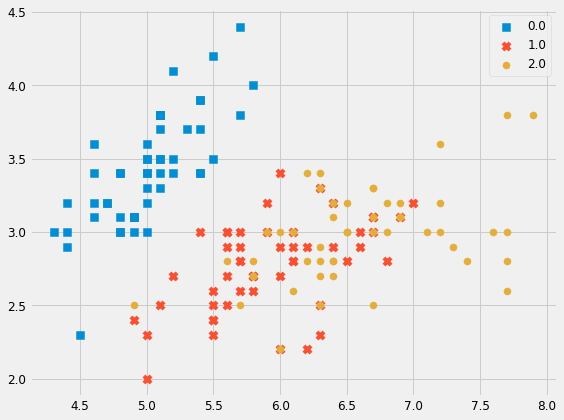

In [26]:
plot_iris(X, y)

# K Means Clustering

In [27]:
# Finding the optimum number of clusters for k-means classification
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(iviris_df.sample(False,0.1, seed=42))
    cost[k] = model.summary.trainingCost

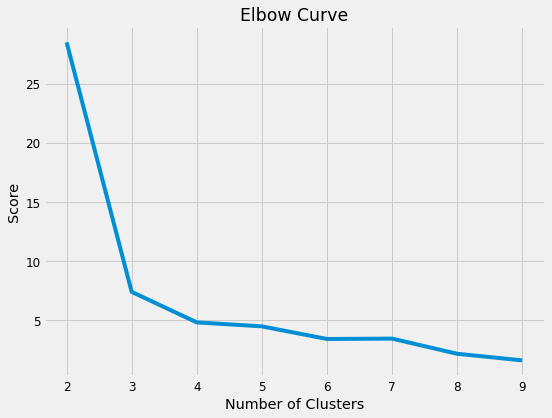

In [28]:
# Plotting the results onto a line graph, 
# `allowing us to observe 'The elbow'
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),cost[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [29]:
# applying k-means to the dataset using feature column
k = 3
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(iviris_df)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[5.88360656 2.74098361 4.38852459 1.43442623]
[5.006 3.418 1.464 0.244]
[6.85384615 3.07692308 5.71538462 2.05384615]


In [42]:
# splitting dataset
train, test = iviris_df.randomSplit([0.70, 0.30], 1)

In [43]:
# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(3).setSeed(1).setFeaturesCol("features")
model = bkm.fit(train)

In [44]:
# Make predictions
predictions = model.transform(test)

In [45]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

In [46]:
# evaluation
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7180555746325292


In [47]:
# Shows the center of cluster
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Cluster Centers: 
[4.96315789 3.24210526 1.61052632 0.29473684]
[5.84634146 2.71707317 4.37560976 1.42439024]
[6.91724138 3.09310345 5.75172414 2.05172414]


In [48]:
SpeciesAndPreds = predictions.select("Species", "prediction").collect()

def getCluster(specie):
    if specie == "Iris-setosa":
        return 0
    elif specie == "Iris-versicolor":
        return 1
    else:
        return 2

def getAccuracy(flowers):
    counter = 0;
    for flower in flowers:
        if getCluster(flower[0]) == flower[1]:
            counter += 1
    return counter / len(flowers)

accuracy = getAccuracy(SpeciesAndPreds)
print("accuracy is " + str(accuracy))

accuracy is 0.8571428571428571


In [49]:
# show prediction
predictions.show(150)

+---+-------------+------------+-------------+------------+---------------+-----------------+-----+----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|        Species|         features|label|prediction|
+---+-------------+------------+-------------+------------+---------------+-----------------+-----+----------+
|  5|          5.0|         3.6|          1.4|         0.2|    Iris-setosa|[5.0,3.6,1.4,0.2]|  0.0|         0|
|  6|          5.4|         3.9|          1.7|         0.4|    Iris-setosa|[5.4,3.9,1.7,0.4]|  0.0|         0|
| 14|          4.3|         3.0|          1.1|         0.1|    Iris-setosa|[4.3,3.0,1.1,0.1]|  0.0|         0|
| 15|          5.8|         4.0|          1.2|         0.2|    Iris-setosa|[5.8,4.0,1.2,0.2]|  0.0|         0|
| 16|          5.7|         4.4|          1.5|         0.4|    Iris-setosa|[5.7,4.4,1.5,0.4]|  0.0|         0|
| 17|          5.4|         3.9|          1.3|         0.4|    Iris-setosa|[5.4,3.9,1.3,0.4]|  0.0|         0|
|